In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})

{'width': 1920, 'height': 1080, 'scroll': True}

# Week 11 (Monday), AST 8581 / PHYS 8581 / CSCI 8581 / STAT 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Jie Ding <dingj@umn.edu>

With contributions totally ripped off from Dima Duev (Weights and Biases), Lex Friedman (MIT), Michael Steinbach (UMN), and Nico Adams (UMN)



# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning -> Deep Learning

<img src='img/fig-dl.png'>

<img src='img/dl6.png'>

<img src='img/dl7.png'>

<img src='img/dl8.png'>

<img src='img/dl13.png'>

# Recipe / Practical advice from one of DL godfathers Andrej Karpathy

Highly recommended: [Andrej Karpathy's blog post](http://karpathy.github.io/2019/04/25/recipe/)

- Neural net training is a leaky abstraction

```bash
>>> your_data = # plug your awesome dataset here
>>> model = SuperCrossValidator(SuperDuper.fit, your_data, ResNet50, SGDOptimizer)
# conquer world here
```

- Neural net training fails silently

Lots of ways to screw things up -> many paths to pain and suffering


## Become one with the data

- probably, the most important and time consuming step
- visualize as much as you can
- check normalizations
    
The neural net is effectively a compressed/compiled version of your dataset, you'll be able to look at your network (mis)predictions and understand where they might be coming from. And if your network is giving you some prediction that doesn't seem consistent with what you've seen in the data, something is off.

#### "If writing your neural net code was like training one, you’d want to use a very small learning rate and guess and then evaluate the full test set after every iteration."

## Set up the end-to-end training/evaluation skeleton

Start out as simple as possible, e.g. a linear classifier, or a very tiny ConvNet. We’ll want to train it, visualize the losses, any other metrics (e.g. accuracy), model predictions, and perform a series of ablation experiments with explicit hypotheses along the way.

### Tips & tricks for this stage:

- **fix random seed**. Always use a fixed random seed to guarantee that when you run the code twice you will get the same outcome. This removes a factor of variation and will help keep you sane.
- **simplify**. Make sure to disable any unnecessary fanciness. As an example, definitely turn off any data augmentation at this stage. Data augmentation is a regularization strategy that we may incorporate later, but for now it is just another opportunity to introduce some dumb bug.
- **add significant digits to your eval**. When plotting the test loss run the evaluation over the entire (large) test set. Do not just plot test losses over batches and then rely on smoothing them in Tensorboard. We are in pursuit of correctness and are very willing to give up time for staying sane.
- **verify loss @ init**. Verify that your loss starts at the correct loss value. E.g. if you initialize your final layer correctly you should measure -log(1/n_classes) on a softmax at initialization. The same default values can be derived for L2 regression, Huber losses, etc.
- **init well.** Initialize the final layer weights correctly. E.g. if you are regressing some values that have a mean of 50 then initialize the final bias to 50. If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.
- **human baseline.** Monitor metrics other than loss that are human interpretable and checkable (e.g. accuracy). Whenever possible evaluate your own (human) accuracy and compare to it. Alternatively, annotate the test data twice and for each example treat one annotation as prediction and the second as ground truth.
- **input-indepent baseline.** Train an input-independent baseline, (e.g. easiest is to just set all your inputs to zero). This should perform worse than when you actually plug in your data without zeroing it out. Does it? i.e. does your model learn to extract any information out of the input at all?
- **overfit one batch.** Overfit a single batch of only a few examples (e.g. as little as two). To do so we increase the capacity of our model (e.g. add layers or filters) and verify that we can reach the lowest achievable loss (e.g. zero). I also like to visualize in the same plot both the label and the prediction and ensure that they end up aligning perfectly once we reach the minimum loss. If they do not, there is a bug somewhere and we cannot continue to the next stage.
- **verify decreasing training loss.** At this stage you will hopefully be underfitting on your dataset because you’re working with a toy model. Try to increase its capacity just a bit. Did your training loss go down as it should?
- **visualize just before the net.** The unambiguously correct place to visualize your data is immediately before your y_hat = model(x) (or sess.run in tf). That is - you want to visualize exactly what goes into your network, decoding that raw tensor of data and labels into visualizations. This is the only “source of truth”. I can’t count the number of times this has saved me and revealed problems in data preprocessing and augmentation.
- **visualize prediction dynamics.** I like to visualize model predictions on a fixed test batch during the course of training. The “dynamics” of how these predictions move will give you incredibly good intuition for how the training progresses. Many times it is possible to feel the network “struggle” to fit your data if it wiggles too much in some way, revealing instabilities. Very low or very high learning rates are also easily noticeable in the amount of jitter.
- **use backprop to chart dependencies.** Your deep learning code will often contain complicated, vectorized, and broadcasted operations. A relatively common bug I’ve come across a few times is that people get this wrong (e.g. they use view instead of transpose/permute somewhere) and inadvertently mix information across the batch dimension. It is a depressing fact that your network will typically still train okay because it will learn to ignore data from the other examples. One way to debug this (and other related problems) is to set the loss to be something trivial like the sum of all outputs of example i, run the backward pass all the way to the input, and ensure that you get a non-zero gradient only on the i-th input. The same strategy can be used to e.g. ensure that your autoregressive model at time t only depends on 1..t-1. More generally, gradients give you information about what depends on what in your network, which can be useful for debugging.
- **generalize a special case.** This is a bit more of a general coding tip but I’ve often seen people create bugs when they bite off more than they can chew, writing a relatively general functionality from scratch. I like to write a very specific function to what I’m doing right now, get that to work, and then generalize it later making sure that I get the same result. Often this applies to vectorizing code, where I almost always write out the fully loopy version first and only then transform it to vectorized code one loop at a time.

# In-class example: Classifying movie reviews: a binary classification example

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.
It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


17465344/17464789 [==============================] - 1s 0us/step


/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])



The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [4]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [5]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 0s 0us/step


In [6]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors.
* We could encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [7]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [9]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. Each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In this problem, we will use two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid activation so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation:

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument:

In [12]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

In [13]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [14]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 263us/step - loss: 0.4978 - binary_accuracy: 0.7865 - val_loss: 0.3719 - val_binary_accuracy: 0.8647
Epoch 2/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.2930 - binary_accuracy: 0.9048 - val_loss: 0.2997 - val_binary_accuracy: 0.8876
Epoch 3/20
15000/15000 [==============================] - 1s 87us/step - loss: 0.2189 - binary_accuracy: 0.9261 - val_loss: 0.2775 - val_binary_accuracy: 0.8892
Epoch 4/20
15000/15000 [==============================] - 1s 84us/step - loss: 0.1697 - binary_accuracy: 0.9447 - val_loss: 0.2779 - val_binary_accuracy: 0.8877
Epoch 5/20
15000/15000 [==============================] - 1s 88us/step - loss: 0.1401 - binary_accuracy: 0.9561 - val_loss: 0.2928 - val_binary_accuracy: 0.8871
Epoch 6/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.1132 - binary_accuracy: 0.9659 - val_loss: 0.3174 - val_binary_

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause 
as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data 
about everything that happened during training. Let's take a look at it:

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

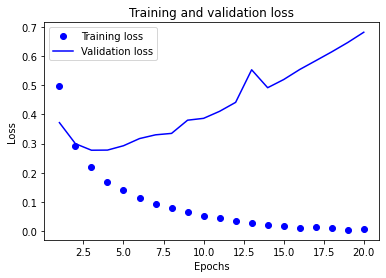

In [18]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

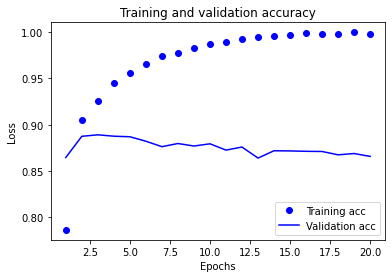

In [19]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. Note that your own results may vary 
slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would 
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that 
isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning 
against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen 
before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we 
ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

Let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [20]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 78us/step - loss: 0.4577 - accuracy: 0.8220
Epoch 2/4
25000/25000 [==============================] - 1s 59us/step - loss: 0.2653 - accuracy: 0.9105
Epoch 3/4
25000/25000 [==============================] - 1s 58us/step - loss: 0.2032 - accuracy: 0.9272
Epoch 4/4
25000/25000 [==============================] - 4s 155us/step


In [21]:
results

[0.30317911993980406, 0.8790799975395203]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

## Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive 
by using the `predict` method:

In [22]:
model.predict(x_test)

array([[0.2491613 ],
       [0.9996889 ],
       [0.919372  ],
       ...,
       [0.19143608],
       [0.10481593],
       [0.7363821 ]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4). 


## Conclusions


Here's what you should take away from this example:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural 
network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will 
likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation, 
i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry 
about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data 
never-seen-before. Make sure to always monitor performance on data that is outside of the training set.


# In-class warm-up: Classifying Type 1a Supernovae Spectra

In this problem, we will be using Deep Learning to differentiate thermonuclear supernovae (SNe Ia) based on very low-resolution (R$\sim100$) data from other transients using a set of spectra from the SED Machine on the Palomar 60 inch; this telescope and observing system has a dedicated program studying bright transients in our local Universe (https://arxiv.org/abs/1910.12973). A significant fraction of those are SNe Ia, which is an explosion that occurs in binary systems where one of the stars is a white dwarf. The other star can be anything from a giant star to an even smaller white dwarf. The goal of the problem is fully automated classification of SNe Ia with a very low false-positive rate (FPR) so that human intervention can be greatly reduced in large-scale SN classification efforts.

Historically, classifications have been based on manual matching of observed spectra to spectral templates, along with careful inspection of each obtained spectrum. This makes classification of thousands of SNe a very time-consuming endeavor. In this problem, we will use a deep-learning based method optimized to identify SNe Ia using SEDM spectra (and potentially determine their redshifts without any human interaction). The data set below comes from SEDM data obtained by the Bright Transient Survey between 2018 March to 2020 March.

### Load in data

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.coordinates import Angle
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt

INFILE='data/SEDM_ML_sample.txt'
names = ('name','type','z','z_host','JD_spec','JD_max','phase','specfile','secure_flag')
df = pd.read_csv(INFILE, names=names)
T = Table.from_pandas(df)

Tval=T[T["secure_flag"]==1] # This selects our published 2018 sample as the validation set
T=T[T["secure_flag"]==0] 

def clean_list(tab):
    tab=tab[tab["type"]!='-']
    tab=tab[tab["type"]!='Iax']
    tab=tab[tab["type"]!='Ia\?']
    tab=tab[tab["type"]!='Ic\?']
    tab=tab[tab["type"]!='Ib/c\?']
    tab=tab[tab["type"]!='duplicate']
    tab=tab[tab["type"]!='ambiguous']

    types = []
    for row in tab:
        if "Ia" in row["type"]:
            types.append(1)
        else:
            types.append(0)
    tab["type"] = types
    
    return tab
    
Tval = clean_list(Tval)
T = clean_list(T)
T=T[T["JD_spec"]-Time('2020-03-01T00:00:00', format='isot', scale='utc').jd<0]

### Pre-process data

In [3]:
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

wls=np.arange(3800,9150,25.6)

def preprocess_list(tab):

    Signals = np.zeros((len(tab), len(wls)))

    print('Preprocessing spectra')
    for ii, row in enumerate(tab):
        if np.mod(ii,500) == 0:
            print('Analyzing %d/%d' % (ii, len(tab)))
        
        spectrafile = 'spectra/%s' % row["specfile"]
        spec = np.loadtxt(spectrafile)
        f = interp1d(spec[:,0], spec[:,1], fill_value="extrapolate")
        ispec = f(wls)
        ispec = ispec / np.median(ispec)
        vals = lowess(ispec, wls, frac=0.3)
        smoothed_ispec = vals[:,1]
    
        spe = ispec/smoothed_ispec
        spe[~np.isfinite(spe)]=0
        Signals[ii,:]=spe
        
    return Signals

Signals = preprocess_list(T)
Signals_val = preprocess_list(Tval)

Preprocessing spectra
Analyzing 0/3092
Analyzing 500/3092
Analyzing 1000/3092
Analyzing 1500/3092
Analyzing 2000/3092
Analyzing 2500/3092
Analyzing 3000/3092
Preprocessing spectra
Analyzing 0/975
Analyzing 500/975


### Plot up some spectra

(-1.0, 2.0)

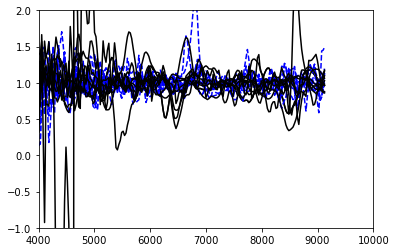

In [4]:

cnt1 = 0
cnt0 = 0
for ii, row in enumerate(Tval):
    if (row["type"] == 1) and (cnt1 < 10):
        plt.plot(wls, Signals_val[ii,:], 'k-')
        cnt1 = cnt1 + 1
    if (row["type"] == 0) and (cnt0 < 10):
        plt.plot(wls, Signals_val[ii,:], 'b--')
        cnt0 = cnt0 + 1
plt.xlim([4000, 10000])
plt.ylim([-1,2])

### Now build the binary classifier: sklearn version

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), 
                           max_iter=10000,
                           activation = 'relu',
                           solver='adam', random_state=1)

pipe = make_pipeline(StandardScaler(), classifier)
pipe.fit(Signals_val, Tval["type"])
pipe.score(Signals,T["type"])


0.7994825355756792

# In-class exercise: Train a set of gravitational-wave noise transients

In [ ]:
!pip install git+https://github.com/Gravity-Spy/gravityspy-ligo-pipeline

  Cloning https://github.com/Gravity-Spy/GravitySpy.git to /tmp/pip-req-build-z8l2d_ht
  Running command git clone -q https://github.com/Gravity-Spy/GravitySpy.git /tmp/pip-req-build-z8l2d_ht
     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 1.4MB 7.5MB/s 
     |████████████████████████████████| 1.6MB 15.7MB/s 
     |████████████████████████████████| 92kB 7.0MB/s 
     |████████████████████████████████| 3.0MB 15.9MB/s 
     |████████████████████████████████| 2.3MB 27.4MB/s 
     |████████████████████████████████| 394.3MB 37kB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.2MB 38.2MB/s 
  Created wheel for redo: filename=redo-2.0.4-cp37-none-any.whl size=11931 s

In [1]:
from gwpy.table import GravitySpyTable
import pandas
import numpy
from gravityspy_ligo.utils import utils
import os
from IPython.display import Image
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Fetch information about glitches that were labeled by the machine learning model as being of class Scattered Light with a probability greater than 90 percent

scattered_light = GravitySpyTable.fetch('gravityspy',
                                        'glitches_public',
                                        host="gravityspyplus.ciera.northwestern.edu",
                                        user="general",
                                        passwd="generalaccess",
                                        selection=['ml_label=Scattered_Light', 'ml_confidence>0.9', "ifo=L1", "links_subjects != 1e+20"],)

blip = GravitySpyTable.fetch('gravityspy',
                                        'glitches_public',
                                        host="gravityspyplus.ciera.northwestern.edu",
                                        user="general",
                                        passwd="generalaccess",
                                        selection=['ml_label=Blip', 'ml_confidence>0.9', "ifo=L1", "links_subjects != 1e+20"],)

whistle = GravitySpyTable.fetch('gravityspy',
                                        'glitches_public',
                                        host="gravityspyplus.ciera.northwestern.edu",
                                        user="general",
                                        passwd="generalaccess",
                                        selection=['ml_label=Whistle', 'ml_confidence>0.9', "ifo=L1", "links_subjects != 1e+20"],)

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/pandas/core/apply.py:285: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  values, self.f, axis=self.axis, dummy=dummy, labels=labels


In [3]:
scattered_light[0:5]

event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,search,process_id,event_id,peak_frequency,central_freq,bandwidth,channel,amplitude,snr,confidence,chisq,chisq_dof,param_one_name,param_one_value,gravityspy_id,Air_Compressor,Blip,Chirp,Extremely_Loud,Helix,Koi_Fish,Light_Modulation,Low_Frequency_Burst,Low_Frequency_Lines,No_Glitch,None_of_the_Above,Paired_Doves,Power_Line,Repeating_Blips,Scattered_Light,Scratchy,Tomte,Violin_Mode,Wandering_Line,Whistle,ml_label,workflow,subjectset,Filename1,Filename2,Filename3,Filename4,upload_flag,1400Ripples,1080Lines,image_status,data_quality,citizen_score,url1,url2,url3,url4,links_subjects,q_value,ml_confidence,vco
float64,str2,int64,int64,int64,int64,float64,str7,int64,int64,float64,float64,float64,str16,float64,float64,int64,int64,int64,str5,float64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str15,int64,int64,str114,str114,str114,str114,float64,float64,float64,str8,str37,float64,str108,str108,str108,str108,float64,float64,float64,float64
1257848627.1875,L1,1257848627,187500000,1257848626,0,2.5,OMICRON,0,172,20.5922603607178,3981.42504882812,7938.11572265625,GDS-CALIB_STRAIN,2.27978994170766e-21,33.4376602172852,0,0,0,phase,0.98854,iUejSgBzDo,0.00104865641333163,0.00112525606527925,1.49947873069323e-05,0.0012171717826277,6.22209336142987e-05,0.00105064455419779,0.00785613805055618,0.00179291679523885,0.0716456845402718,0.000232217338634655,0.0295043792575598,2.76058708550408e-05,0.00073269271524623,0.00018049799837172,0.87548828125,2.68188614427345e-05,0.000291231932351366,0.00489901006221771,0.000607781985308975,0.00139363307971507,Scattered_Light,7767,67447,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_iUejSgBzDo_spectrogram_0.5.png,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_iUejSgBzDo_spectrogram_1.0.png,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_iUejSgBzDo_spectrogram_2.0.png,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_iUejSgBzDo_spectrogram_4.0.png,1.0,0.000146321253851056,0.000655837648082525,testing,no_flag,0.0,https://panoptes-uploads.zooniverse.org/production/subject_location/c032b02e-985b-4b76-9a07-d2e7f86085d8.png,https://panoptes-uploads.zooniverse.org/production/subject_location/98decb5d-1262-4457-aa74-5a86a36d54a2.png,https://panoptes-uploads.zooniverse.org/production/subject_location/201d8a00-a893-4066-b3e1-1f7898921109.png,https://panoptes-uploads.zooniverse.org/production/subject_location/6082e5a6-12f3-4edb-8449-406ca2c9ce68.png,38145052.0,45.254833995939,0.9830797910690308,1e+20
1257857481.6875,L1,1257857481,687500000,1257857480,875000000,1.75,OMICRON,0,181,31.0353698730469,2338.78466796875,4657.5693359375,GDS-CALIB_STRAIN,1.50702005714828e-22,8.27892971038818,0,0,0,phase,-1.32149,r3UEVSqr5s,0.000525581941474229,9.10286689759232e-06,7.20111415830615e-07,5.89432493143249e-05,0.000101220168289728,0.000222265429329127,0.000288932438706979,0.00176390667911619,0.00107623788062483,4.5674303692067e-05,0.000588849012274295,1.87146524694981e-05,6.03821808908833e-06,4.87669467474916e-06,0.993364572525024,4.41728798250551e-06,3.64237439498538e-06,8.97344361874275e-05,1.06232855614508e-05,0.00177560292650014,Scattered_Light,7765,67446,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_r3UEVSqr5s_spectrogram_0.5.png,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_r3UEVSqr5s_spectrogram_1.0.png,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_r3UEVSqr5s_spectrogram_2.0.png,/home/gravityspy/public_html/runs/O3/uZ6k12GBwL/L1_r3UEVSqr5s_spectrogram_4.0.png,1.0,3.49223023476952e-06,3.68726578017231e-05,testing,no_flag,0.0,https://panoptes-uploads.zooniverse.org/production/subject_location/166c35fb-d354-42cd-a08b-a0cee042f18a.png,https://panoptes-uploads.zooniverse.org/production/subject_location/6bbb8763-1b41-4ebb-b00e-a38ef81bd6e9.png,https://panoptes-uploads.zooniverse.org/production/subject_location/692ede60-ca7

In [5]:
# We have downloaded some PNGs into ./download, on the left under files you should see the new folder
# lets see what it looks like!
os.listdir("download")[0:4]

['L1_r3UEVSqr5s_spectrogram_1.0.png',
 'L1_iUejSgBzDo_spectrogram_1.0.png',
 'L1_Bf09uarKBg_spectrogram_1.0.png',
 'L1_mMyyLACK7X_spectrogram_4.0.png']

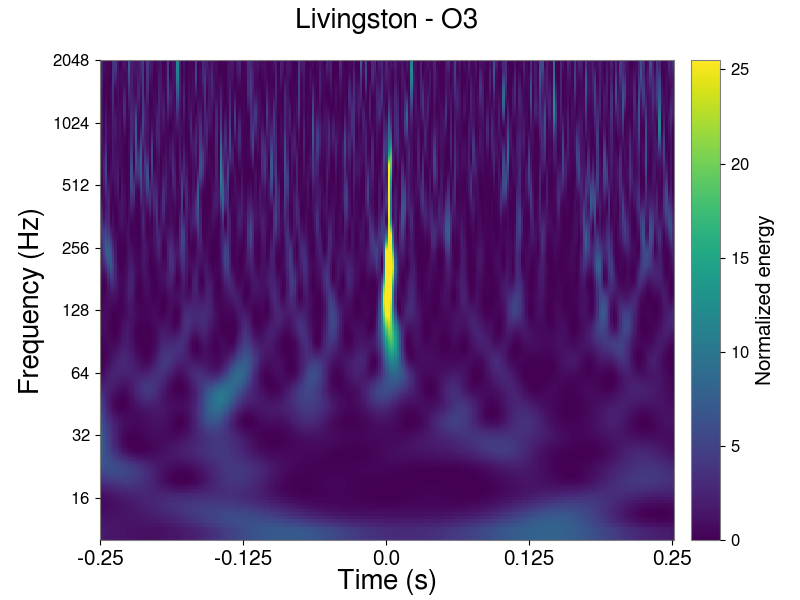

In [7]:
# Blip
Image("./download/L1_{0}_spectrogram_0.5.png".format(blip[0:1]["gravityspy_id"][0]))

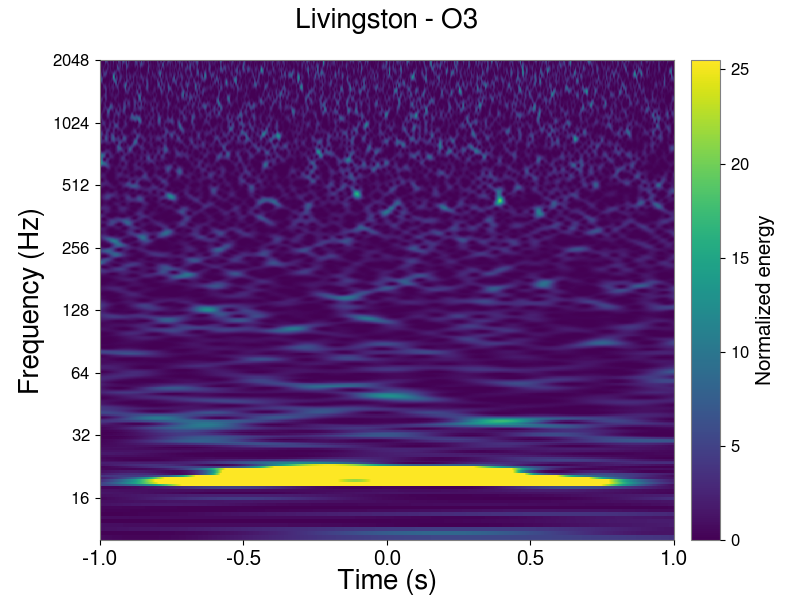

In [8]:
# Scattered_Light
Image("./download/L1_{0}_spectrogram_2.0.png".format(scattered_light[0:1]["gravityspy_id"][0]))

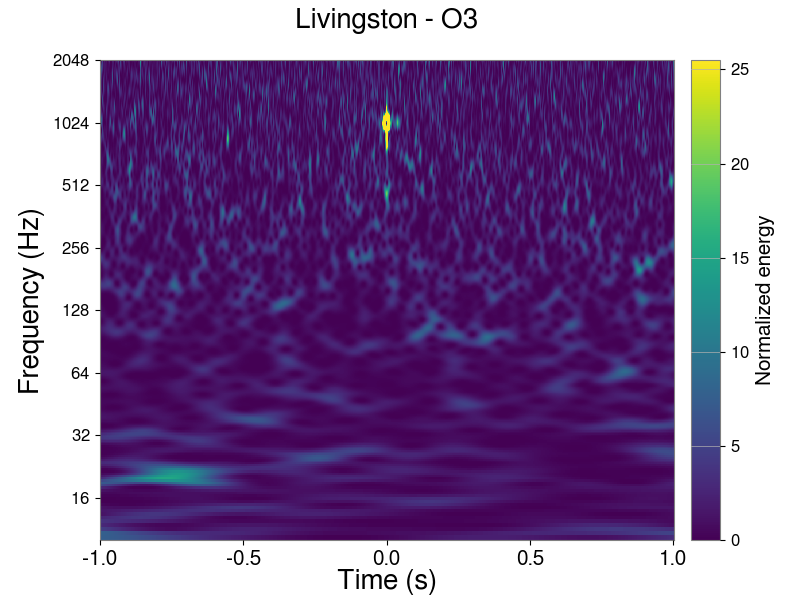

In [9]:
# Whistle
Image("./download/L1_{0}_spectrogram_2.0.png".format(whistle[0:1]["gravityspy_id"][0]))

# Scattered Light
![](/content/download/L1_7jxQwoUCx0_spectrogram_4.0.png)


In [10]:
# convert to a pandas data frame for easier data manipulation
scattered_light_df = scattered_light.to_pandas()

In [11]:
from gwpy.time import from_gps

In [12]:
scattered_light_df["event_time_calendar"] = scattered_light_df["event_time"].apply(from_gps)

In [13]:
print(scattered_light_df["event_time_calendar"].min())
print(scattered_light_df["event_time_calendar"].max())

2015-09-27 21:42:38.687500
2020-03-23 15:11:45.687500


# Download the Gravity Spy model

In [14]:
# get the original O3 model
!wget https://github.com/Gravity-Spy/GravitySpy/raw/develop/models/O3-multiview-classifer.h5 -O original-O3-model.hdf5
# get an updated model with new classes and slightly different training samples
!wget https://github.com/Gravity-Spy/GravitySpy/blob/develop/models/sidd-cqg-paper-O3-model.h5?raw=true -O updated-O3-model.hdf5

--2021-03-25 18:18:45--  https://github.com/Gravity-Spy/GravitySpy/raw/develop/models/O3-multiview-classifer.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Gravity-Spy/GravitySpy/develop/models/O3-multiview-classifer.h5 [following]
--2021-03-25 18:18:46--  https://raw.githubusercontent.com/Gravity-Spy/GravitySpy/develop/models/O3-multiview-classifer.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45567080 (43M) [application/octet-stream]
Saving to: ‘original-O3-model.hdf5’

original-O3-model.h 100%[===================>]  43.46M  42.3MB/s    in 1.0s    

2021-03-25 18:18:48 (42.3 MB/s) - ‘

In [ ]:
# pass a folder containing the images and the full path to where the trained model weights live
original_O3_label = utils.label_q_scans('download', path_to_cnn='./original-O3-model.hdf5')
new_O3_label = utils.label_q_scans('download', path_to_cnn='./updated-O3-model.hdf5')

In [ ]:
# These are the labels from the original O3 model
print(original_O3_label["ml_label", "ml_confidence", "gravityspy_id"])

    ml_label    ml_confidence gravityspy_id
--------------- ------------- -------------
Repeating_Blips    0.43449175    1ZMVm1NZkx
           Blip    0.88327354    6GoqReKlpf
        Whistle     0.9978897    6rDMoPiN9B
Scattered_Light    0.94341123    7jxQwoUCx0
Scattered_Light    0.20768374    DWgrfxtO59
           Blip      0.762731    GKgArMQmnx
 Extremely_Loud     0.3979834    MjLpkRooYn
       Koi_Fish     0.5562936    SFNPOWxfKe
    Violin_Mode    0.48227596    VBoT4YYVub
 Extremely_Loud    0.18309873    ZGRSu6iXgj
Scattered_Light     0.8846876    eUS12LOTyh
Scattered_Light    0.31269357    fATHCOhb3c
        Whistle     0.3468838    jzN992wkQO
           Blip    0.57967037    lo1vZhJkg1
        Whistle    0.48958865    y5xfwoOzjC


In [ ]:
# These are the labels from the new O3 model
print(new_O3_label["ml_label", "ml_confidence", "gravityspy_id"])

     ml_label      ml_confidence gravityspy_id
------------------ ------------- -------------
Blip_Low_Frequency     0.9995958    1ZMVm1NZkx
              Blip    0.99967563    6GoqReKlpf
           Whistle    0.99999917    6rDMoPiN9B
   Scattered_Light     0.9993173    7jxQwoUCx0
   Scattered_Light    0.99129796    DWgrfxtO59
              Blip     0.9998925    GKgArMQmnx
           Whistle    0.57591486    MjLpkRooYn
Blip_Low_Frequency    0.73376215    SFNPOWxfKe
           Whistle     0.9120326    VBoT4YYVub
   Scattered_Light    0.46302003    ZGRSu6iXgj
   Scattered_Light     0.9990932    eUS12LOTyh
   Scattered_Light     0.9999969    fATHCOhb3c
           Whistle     0.9999795    jzN992wkQO
              Blip     0.9970053    lo1vZhJkg1
           Whistle    0.99697673    y5xfwoOzjC


In [ ]:
# These are the classifications and confidence values from the glitch table
print(scattered_light[0:5]["ml_label", "ml_confidence", "gravityspy_id"])
print(blip[0:5]["ml_label", "ml_confidence", "gravityspy_id"])
print(whistle[0:5]["ml_label", "ml_confidence", "gravityspy_id"])

# Train a model

In [ ]:
from keras.utils import np_utils

# Load in the training set data that is in the form of a pickle file
trainingset_df = pandas.read_pickle("data/50_images_each_class.pkl")

# randomly shuffle the training data
trainingset_df = trainingset_df.sample(n=len(trainingset_df))

# convert class names to integers

classes = dict(enumerate(sorted(trainingset_df.true_label.unique())))
classes = dict((str(v),k) for k,v in classes.items())

trainingset_df["true_label_integer"] = trainingset_df.true_label.apply(lambda x: classes[x])

# We need to take the numpy array and reshape it into 
# (N samples, width (of each samples), height (of each sample), number of features each samples has)
img_rows =140
img_cols = 170
reshape_order = (-1, img_rows, img_cols, 1)
training_data = numpy.vstack(trainingset_df["1.0.png"]).reshape(reshape_order)

# convert integer labels to a categorical matrix.
trainingset_labels = numpy.vstack(trainingset_df.true_label_integer.values)

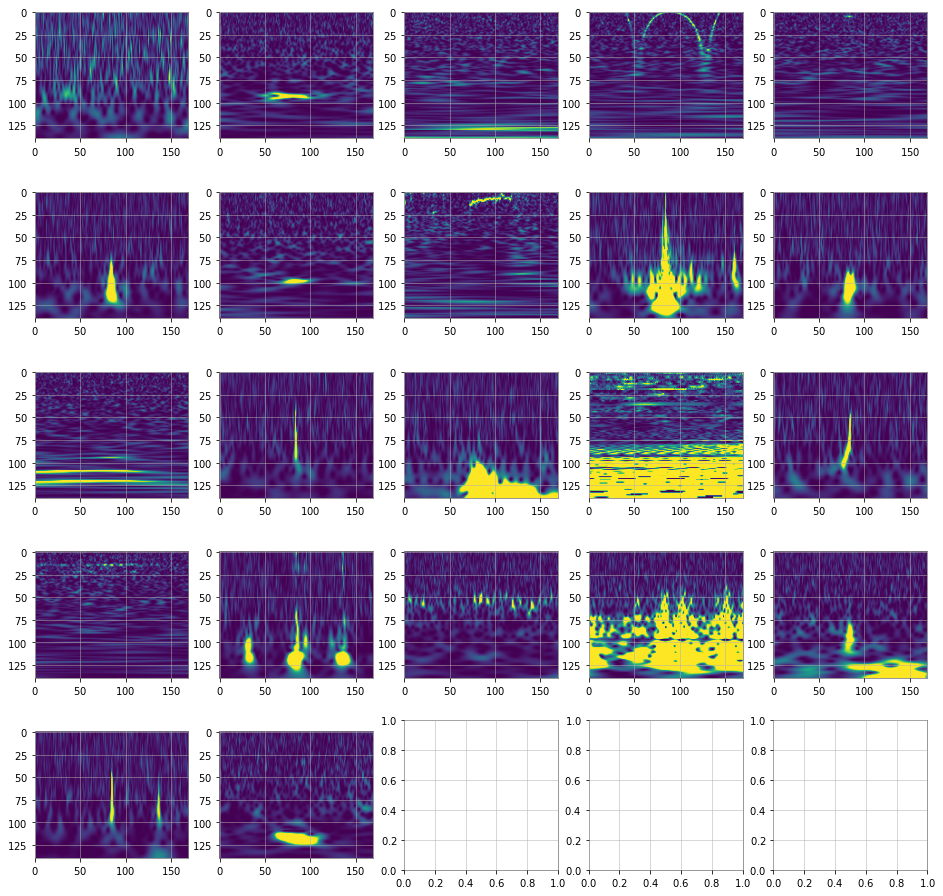

In [ ]:
# Display an example of each class
from matplotlib import pyplot

fig, axes =  pyplot.subplots(5, 5, figsize=(16,16))

for class_name, ax  in zip(trainingset_df.true_label.unique(), axes.flatten()):
  class_idx = numpy.where(trainingset_df["true_label"] == class_name)[0][0]
  ax.imshow(training_data[class_idx, :, :, 0])

## Build your own model: how well can you do?

In [ ]:
# Create a model
from tensorflow.keras import layers, models
import tensorflow as tf

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=training_data.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(trainingset_df.true_label.unique().size, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 136, 166, 16)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 68, 83, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 79, 16)        6416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 39, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 35, 32)        12832     
_________________________________________________________________
flatten_1 (Flatten)          (None, 31360)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(training_data, trainingset_labels, epochs=10, 
                    validation_split=0.1, batch_size=100,)

Epoch 1/10
10/10 [==============================] - 24s 2s/step - loss: 3.0252 - accuracy: 0.0873 - val_loss: 2.6098 - val_accuracy: 0.2897
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 2.5565 - accuracy: 0.2808 - val_loss: 2.2153 - val_accuracy: 0.3832
Epoch 3/10
10/10 [==============================] - 22s 2s/step - loss: 2.1030 - accuracy: 0.4020 - val_loss: 1.8530 - val_accuracy: 0.4112
Epoch 4/10
10/10 [==============================] - 22s 2s/step - loss: 1.6367 - accuracy: 0.4939 - val_loss: 1.3594 - val_accuracy: 0.5140
Epoch 5/10
10/10 [==============================] - 22s 2s/step - loss: 1.1997 - accuracy: 0.6308 - val_loss: 1.0120 - val_accuracy: 0.6636
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.8155 - accuracy: 0.7557 - val_loss: 0.7146 - val_accuracy: 0.7196
Epoch 7/10
10/10 [==============================] - 22s 2s/step - loss: 0.5708 - accuracy: 0.8406 - val_loss: 0.5679 - val_accuracy: 0.8318
Epoch 8/10
10/10 [==

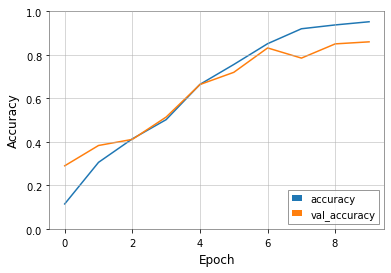

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.plot(history.history['val_accuracy'], label = 'val_accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.ylim([0, 1])
pyplot.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


# In-class exercise: Classifying Type 1a Supernovae Spectra (tensorflow version)

In [11]:
import os
import json
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf
from abc import ABC, abstractmethod
from collections import defaultdict

class Dataset(object):

    def __init__(
        self, dataset, labels,
        verbose=False,
        **kwargs
    ):
        """
        load csv file produced by labels*.ipynb

        :param tag:
        :param path_labels:
        :param features:
        :param verbose:
        """
        self.verbose = verbose
        self.df_ds = pd.DataFrame(dataset)
        self.target = labels
   
    @staticmethod
    def threshold(a, t: float = 0.5):
        b = np.zeros_like(a)
        b[np.array(a) > t] = 1
        return b

    def make(
        self, target_label: str = 'variable', threshold: float = 0.5, balance=None, weight_per_class: bool = True,
        test_size: float = 0.1, val_size: float = 0.1, random_state: int = 42,
        path_norms=None, batch_size: int = 256, shuffle_buffer_size: int = 256, epochs: int = 300,
        **kwargs
    ):
        """
        make datasets for target_label

        :param target_label:
        :param threshold:
        :param balance:
        :param weight_per_class:
        :param test_size:
        :param val_size:
        :param random_state:
        :param path_norms: json file with norms to use to normalize features. if None, norms are computed
        :param batch_size
        :param shuffle_buffer_size
        :param epochs
        :return:
        """

        # target = np.asarray(list(map(int, np.rint(self.df_ds[target_label].values))))
        target = np.asarray(list(map(int, self.threshold(self.target, t=threshold))))

        self.target = np.expand_dims(target, axis=1)
        
        neg, pos = np.bincount(target.flatten())
        total = neg + pos
        if self.verbose:
            print(f'Examples:\n  Total: {total}\n  Positive: {pos} ({100 * pos / total:.2f}% of total)\n')

        w_pos = np.where(np.rint(self.target) == 1)[0]
        index_pos = self.df_ds.loc[w_pos].index
        w_neg = np.where(np.rint(self.target) == 0)[0]
        index_neg = self.df_ds.loc[w_neg].index

        # balance positive and negative examples if there are more negative than positive?
        index_neg_dropped = None
        if balance:
            neg_sample_size = int(np.sum(w_pos) * balance)
            index_neg = self.df_ds.loc[w_neg].sample(n=neg_sample_size, random_state=1, replace=True).index
            index_neg_dropped = self.df_ds.loc[list(set(self.df_ds.loc[w_neg].index) - set(index_neg))].index

        ds_indexes = index_pos.to_list() + index_neg.to_list()

        # Train/validation/test split (we will use an 81% / 9% / 10% data split by default):

        train_indexes, test_indexes = train_test_split(ds_indexes, shuffle=True,
                                                       test_size=test_size, random_state=random_state)
        train_indexes, val_indexes = train_test_split(train_indexes, shuffle=True,
                                                      test_size=val_size, random_state=random_state)

        # Normalize features (dmdt's are already L2-normalized) (?using only the training samples?).
        # Obviously, the same norms will have to be applied at the testing and serving stages.

        # load/compute feature norms:
        norms = np.linalg.norm(self.df_ds.loc[ds_indexes, :], axis=0)
        
        for idx in ds_indexes:
            self.df_ds.loc[idx, :] = self.df_ds.loc[idx, :] / norms
        
        # make tf.data.Dataset's:
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[train_indexes].values},
             target[train_indexes])
        )
        
        val_dataset = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[val_indexes].values},
             target[val_indexes])
        )
        test_dataset = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[test_indexes].values},
             target[test_indexes])
        )
        dropped_negatives = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[index_neg_dropped].values},
             target[index_neg_dropped])
        ) if balance else None

        # Shuffle and batch the datasets:
        train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).repeat(epochs)
        val_dataset = val_dataset.batch(batch_size).repeat(epochs)
        test_dataset = test_dataset.batch(batch_size)

        dropped_negatives = dropped_negatives.batch(batch_size) if balance else None

        datasets = {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
            'dropped_negatives': dropped_negatives,
        }

        indexes = {
            'train': np.array(train_indexes),
            'val': np.array(val_indexes),
            'test': np.array(test_indexes),
            'dropped_negatives': np.array(index_neg_dropped.to_list()) if index_neg_dropped is not None else None,
        }

        # How many steps per epoch?

        steps_per_epoch_train = len(train_indexes) // batch_size - 1
        steps_per_epoch_val = len(val_indexes) // batch_size - 1
        steps_per_epoch_test = len(test_indexes) // batch_size - 1

        steps_per_epoch = {'train': steps_per_epoch_train,
                           'val': steps_per_epoch_val,
                           'test': steps_per_epoch_test}
        if self.verbose:
            print(f'Steps per epoch: {steps_per_epoch}')

        # Weight training data depending on the number of samples?
        # Very useful for imbalanced classification, especially when in the cases with a small number of examples.

        if weight_per_class:
            # weight data class depending on number of examples?
            # num_training_examples_per_class = np.array([len(target) - np.sum(target), np.sum(target)])
            num_training_examples_per_class = np.array([len(index_neg), len(index_pos)])

            assert 0 not in num_training_examples_per_class, 'found class without any examples!'

            # fewer examples -- larger weight
            weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
            normalized_weight = weights / np.max(weights)

            class_weight = {i: w for i, w in enumerate(normalized_weight)}

        else:
            # working with binary classifiers only
            class_weight = {i: 1 for i in range(2)}

        return datasets, indexes, steps_per_epoch, class_weight

class AbstractClassifier(ABC):

    def __init__(self, name):
        # classifier name: label_classifier
        self.name = name
        # model that will be trained and evaluated
        self.model = None
        # metadata needed to set up the classifier
        self.meta = defaultdict(str)

    @abstractmethod
    def setup(self, **kwargs):
        pass

    @abstractmethod
    def load(self, **kwargs):
        pass

    @abstractmethod
    def train(self, **kwargs):
        pass

    @abstractmethod
    def evaluate(self, **kwargs):
        pass

    @abstractmethod
    def predict(self, **kwargs):
        pass

    @abstractmethod
    def save(self, **kwargs):
        pass

class DNN(AbstractClassifier):
    """
        Baseline model with a statically-defined graph
    """

    def setup(self, features_shape=(41, ), dmdt_shape=(26, 26, 1), dense_branch=True, conv_branch=True,
              loss='binary_crossentropy', optimizer='adam', callbacks=('early_stopping', 'tensorboard'),
              tag=None, logdir='logs', **kwargs):

        tf.keras.backend.clear_session()

        self.model = self.build_model(features_shape=features_shape, dmdt_shape=dmdt_shape,
                                      dense_branch=dense_branch, conv_branch=conv_branch)

        self.meta['loss'] = loss
        if optimizer == 'adam':
            lr = kwargs.get('lr', 3e-4)
            beta_1 = kwargs.get('beta_1', 0.9)
            beta_2 = kwargs.get('beta_2', 0.999)
            epsilon = kwargs.get('epsilon', 1e-7)  # None?
            decay = kwargs.get('decay', 0.0)
            amsgrad = kwargs.get('amsgrad', 3e-4)
            self.meta['optimizer'] = tf.keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2,
                                                              epsilon=epsilon, decay=decay, amsgrad=amsgrad)
        elif optimizer == 'sgd':
            lr = kwargs.get('lr', 3e-4)
            momentum = kwargs.get('momentum', 0.9)
            decay = kwargs.get('epsilon', 1e-6)
            nesterov = kwargs.get('nesterov', True)
            self.meta['optimizer'] = tf.keras.optimizers.SGD(lr=lr, momentum=momentum, decay=decay, nesterov=nesterov)
        else:
            print('Could not recognize optimizer, using Adam with default params')
            self.meta['optimizer'] = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                                              epsilon=1e-7, decay=0.0, amsgrad=False)

        self.meta['metrics'] = [tf.keras.metrics.TruePositives(name='tp'),
                                tf.keras.metrics.FalsePositives(name='fp'),
                                tf.keras.metrics.TrueNegatives(name='tn'),
                                tf.keras.metrics.FalseNegatives(name='fn'),
                                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc'),
                                ]

        self.meta['callbacks'] = []
        # self.meta['callbacks'] = [TqdmCallback(verbose=1)]
        for callback in set(callbacks):
            if callback == 'early_stopping':
                # halt training if no gain in <validation loss> over <patience> epochs
                monitor = kwargs.get('monitor', 'val_loss')
                patience = kwargs.get('patience', 3)
                restore_best_weights = kwargs.get('restore_best_weights', True)
                early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                                           patience=patience,
                                                                           restore_best_weights=restore_best_weights)
                self.meta['callbacks'].append(early_stopping_callback)

            elif callback == 'tensorboard':
                # logs for TensorBoard:
                if tag:
                    log_tag = f'{self.name.replace(" ", "_")}-{tag}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                else:
                    log_tag = f'{self.name.replace(" ", "_")}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                logdir_tag = os.path.join('logs', log_tag)
                tensorboard_callback = tf.keras.callbacks.TensorBoard(os.path.join(logdir_tag, log_tag),
                                                                      histogram_freq=1)
                self.meta['callbacks'].append(tensorboard_callback)

        self.model.compile(optimizer=self.meta['optimizer'],
                           loss=self.meta['loss'],
                           metrics=self.meta['metrics'])

    @staticmethod
    def build_model(features_shape: tuple = (len(wls),),
                    dense_branch: bool = True, conv_branch: bool = False, **kwargs):

        if (not dense_branch) and (not conv_branch):
            raise ValueError('model must have at least one branch')

        features_input = tf.keras.Input(shape=features_shape, name='features')

        # dense branch to digest features
        if dense_branch:            
            x_dense = tf.keras.layers.Dense(256, activation='relu', name='dense_fc_1')(features_input)
            x_dense = tf.keras.layers.Dropout(0.35)(x_dense)
            #x_dense = tf.keras.layers.LSTM(32, activation='relu', 
            #                               name='lstm_fc_2', return_sequences=False)(x_dense)
            x_dense = tf.keras.layers.Dense(32, activation='relu', name='dense_fc_2')(x_dense)
            x_dense = tf.keras.layers.Dropout(0.25)(x_dense)    
            x_dense = tf.keras.layers.Dense(2, activation='relu', name='dense_fc_3')(x_dense)
            x_dense = tf.keras.layers.Softmax()(x_dense)
            
        # CNN branch to digest dmdt
        if conv_branch:
            x_conv = tf.keras.layers.SeparableConv2D(16, (3, 3), activation='relu', name='conv_conv_1')(dmdt_input)
            x_conv = tf.keras.layers.SeparableConv2D(16, (3, 3), activation='relu', name='conv_conv_2')(x_conv)
            x_conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_conv)
            x_conv = tf.keras.layers.Dropout(0.25)(x_conv)

            x_conv = tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', name='conv_conv_3')(x_conv)
            x_conv = tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', name='conv_conv_4')(x_conv)
            x_conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_conv)
            x_conv = tf.keras.layers.Dropout(0.25)(x_conv)

            x_conv = tf.keras.layers.GlobalAveragePooling2D()(x_conv)

        # concatenate
        if dense_branch and conv_branch:
            x = tf.keras.layers.concatenate([x_dense, x_conv])
        elif dense_branch:
            x = x_dense
        elif conv_branch:
            x = x_conv

        # one more dense layer?
        #x = tf.keras.layers.Dense(16, activation='relu', name='fc_1')(x)

        # Logistic regression to output the final score
        x = tf.keras.layers.Dense(1, activation='sigmoid', name='score')(x)

        m = tf.keras.Model(inputs=[features_input], outputs=x)

        return m

    def train(self, train_dataset, val_dataset, steps_per_epoch_train, steps_per_epoch_val,
              epochs=300, class_weight=None, verbose=0):

        if not class_weight:
            # all our problems here are binary classification ones:
            class_weight = {i: 1 for i in range(2)}

        self.meta['history'] = self.model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch_train,
                                              validation_data=val_dataset, validation_steps=steps_per_epoch_val,
                                              class_weight=class_weight, callbacks=self.meta['callbacks'],
                                              verbose=verbose)

    def evaluate(self, test_dataset, **kwargs):
        return self.model.evaluate(test_dataset, **kwargs)

    def predict(self, x, **kwargs):
        return self.model.predict(x, **kwargs)

    def load(self, path_model, **kwargs):
        self.model = tf.keras.models.load_model(path_model, **kwargs)

    def save(self, output_path='./', output_format='hdf5', tag=None):

        assert output_format in ('SavedModel', 'hdf5'), 'unknown output format'

        output_name = self.name if not tag else f'{self.name}.{tag}'

        if (output_path != './') and (not os.path.exists(output_path)):
            os.makedirs(output_path)

        if output_format == 'SavedModel':
            self.model.save(os.path.join(output_path, output_name))
        elif output_format == 'hdf5':
            self.model.save(os.path.join(output_path, f'{output_name}.h5'))
            

In [17]:
ds = Dataset(dataset=Signals_val,
             labels=Tval["type"],
             verbose=True)

balance = True
threshold = 0.7
weight_per_class = False
test_size = 0.1
val_size = 0.1
random_state = 42
batch_size = 16
shuffle_buffer_size = 64
epochs = 10
normFile = False
    
datasets, indexes, steps_per_epoch, class_weight = ds.make(
    threshold=threshold,
    balance=balance, weight_per_class=weight_per_class,
    test_size=test_size, val_size=val_size, random_state=random_state,
    path_norms=normFile,
    batch_size=batch_size, shuffle_buffer_size=shuffle_buffer_size,
    epochs=epochs
)  

Examples:
  Total: 975
  Positive: 582 (59.69% of total)

Steps per epoch: {'train': 14506, 'val': 1611, 'test': 1790}


We now train our model.

In [14]:
from tqdm.keras import TqdmCallback

classifier = DNN(name='SN')
classifier.setup(features_shape=(len(wls),),
                 dense_branch=True, conv_branch=False,
                 loss='binary_crossentropy', optimizer='adam', lr=3e-4, momentum=0.9,
                 monitor='loss', patience=30,
                 callbacks=('early_stopping', 'tensorboard'),
                 tag='v1', logdir='logs') 

print(classifier.model.summary())
   
class_weight = {0: 1, 1: 1}
classifier.meta['callbacks'].append(TqdmCallback(verbose=1))
classifier.train(datasets['train'], datasets['val'],
                 steps_per_epoch['train'], steps_per_epoch['val'],
                 epochs=epochs, class_weight=class_weight, verbose=0)

stats = classifier.evaluate(datasets['test'],
                            verbose=0)
print(stats)
classifier.save(output_path='models',
                output_format='hdf5', tag='dnn_v2')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 209)]             0         
_________________________________________________________________
dense_fc_1 (Dense)           (None, 256)               53760     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_fc_2 (Dense)           (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_fc_3 (Dense)           (None, 2)                 66        
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0     

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

[0.015236692761723186, 0.0, 0.0, 28596.0, 62.0, 0.99783653, 0.0, 0.0, 1.0]


In [15]:
ds = Dataset(dataset=Signals_val,
             labels=Tval["type"],
             verbose=True)

data = tf.data.Dataset.from_tensor_slices(
        ({'features': ds.df_ds.values}, ds.target)
)

predictions = classifier.predict(data.batch(len(ds.df_ds)))

pt = np.vstack((np.squeeze(predictions), ds.target)).T
pt_thresholded = np.rint(pt)
w = np.logical_xor(pt_thresholded[:, 0], pt_thresholded[:, 1])
   
print(len(w), np.sum(w), np.sum(w)/len(w))

975 582 0.5969230769230769


<BarContainer object of 20 artists>

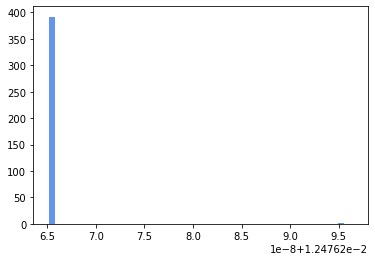

In [16]:

idx = np.where(ds.target == 0)[0]
a_heights, a_bins = np.histogram(predictions[idx],bins=20)
idx = np.where(ds.target == 1)[0]
b_heights, b_bins = np.histogram(predictions[idx], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

plt.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
plt.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')